In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


### Import necessary libraries

In [2]:
import torch
import numpy as np 
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
!pip install diffusers transformers accelerate scipy safetensors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 104.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.7 MB/s eta 0:00:00


In [4]:
from diffusers import StableDiffusionInpaintPipeline

### Getting the dataset

In [5]:
cat_mask_data = pd.read_csv("/content/drive/MyDrive/DL_Project/photo-reconstruction/Dataset/Training_Data/Cat/Masked_Train/masked_info.csv").drop(['Unnamed: 0'],axis=1)
cat_mask_data.head()

,filename,box1_row,box1_col,box2_row,box2_col
0,Cat-Train (1085).jpeg,67,6,41,152
1,Cat-Train (900).jpeg,86,23,105,165
2,Cat-Train (1759).jpeg,60,99,3,140
3,Cat-Train (969).jpeg,14,138,47,137
4,Cat-Train (1559).jpeg,106,95,41,158


In [6]:
cat_mask_data.dtypes

filename    object
box1_row     int64
box1_col     int64
box2_row     int64
box2_col     int64
dtype: object

In [7]:
filename, x1, y1, x2, y2 = cat_mask_data.loc[54,]

In [8]:
filepath_unmasked = '/content/drive/MyDrive/DL_Project/photo-reconstruction/Dataset/Training_Data/Cat/Unmasked_Train/'
filepath_masked = '/content/drive/MyDrive/DL_Project/photo-reconstruction/Dataset/Training_Data/Cat/Masked_Train/'

In [9]:
unmasked_image = Image.open(filepath_unmasked + filename)
masked_image = Image.open(filepath_masked + filename)

<Figure size 640x480 with 0 Axes>

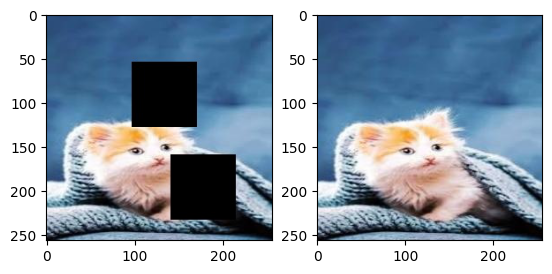

In [10]:
plt.figure()
_, axarr = plt.subplots(1,2) 
axarr[0].imshow(masked_image)
axarr[1].imshow(unmasked_image);

### Creating the mask for input in Stable Diffusion

In [11]:
def create_mask(filename, dataset):
    y1, x1, y2, x2 = dataset[dataset['filename'] == filename].iloc[0,1:]
    mask = Image.new(mode="RGB", size=(256, 256))
    for i in range(x1, x1+75): 
        for j in range(y1, y1+75):
            mask.putpixel((i,j),(255,255,255)) # for every pixel:
    for i in range(x2, x2+75): 
        for j in range(y2, y2+75):
            mask.putpixel((i,j),(255,255,255)) # for every pixel:
    return mask

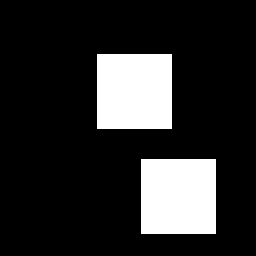

In [12]:
mask = create_mask(filename, cat_mask_data)
mask

### Download and loading the pre-trained Stable Diffusion

In [13]:
pipe = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting", revision="fp16", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

vae/diffusion_pytorch_model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [14]:
unmasked_image = unmasked_image.resize((512,512))
mask = mask.resize((512,512))
image = pipe(prompt="This is an image of Cat", image=unmasked_image, mask_image=mask).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

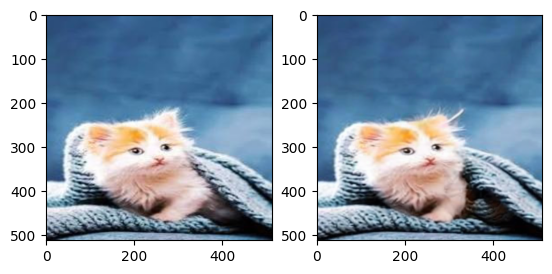

In [15]:
plt.figure()
_, axarr = plt.subplots(1,2) 
axarr[0].imshow(unmasked_image)
axarr[1].imshow(image);

### Creating the final Submission csv file

In [18]:
def submission_csv_function (test_path):
  
    test_mask_data = pd.read_csv(test_path + 'masked_info.csv').drop(['Unnamed: 0'],axis=1)
    submission = []
    for i in range(len(test_mask_data)):
        print(i+1)
        filename, y1, x1, y2, x2 = test_mask_data.loc[i,]
        mask = create_mask(filename, test_mask_data)
        mask = mask.resize((512,512))
        masked_image = Image.open(test_path + filename).resize((512,512))

        img_name_2 = str(filename).split("-")[0]

        img_name = img_name_2.split(" ")[0]
        
        prompt = f"This is an image of {img_name}."
        image = pipe(prompt= prompt, image=masked_image, mask_image=mask).images[0]



        image = image.resize((256, 256))
        im = np.array(image)
        b, g, r = cv.split(im)
        result = np.zeros((256, 256))
        normalized_b = cv.normalize(b,result, 0, 1, cv.NORM_MINMAX, dtype=cv.CV_32F)
        normalized_g = cv.normalize(g,result, 0, 1, cv.NORM_MINMAX, dtype=cv.CV_32F)
        normalized_r = cv.normalize(r,result, 0, 1, cv.NORM_MINMAX, dtype=cv.CV_32F)
        for i in range(y1 , y1+75):
            for j in range(x1, x1+75):
                temp1 = filename + '_' + 'box1' + '_' +  str(i) + '_' + str(j) + '_'
                submission.append((temp1 + '0', normalized_b[i,j]))
                submission.append((temp1 + '1', normalized_g[i,j]))
                submission.append((temp1 + '2', normalized_r[i,j]))
        for i in range(y2 , y2+75):
            for j in range(x2, x2+75):
                temp1 = filename + '_' + 'box2' + '_' + str(i) + '_' + str(j) + '_'
                submission.append((temp1 + '0', normalized_b[i,j]))
                submission.append((temp1 + '1', normalized_g[i,j]))
                submission.append((temp1 + '2', normalized_r[i,j]))
        df = pd.DataFrame(submission, columns=['filename_box_pixel','value'])

    return df 

In [19]:
test_path = '/content/drive/MyDrive/DL_Project/photo-reconstruction/Dataset/Testing_Data/'
df = submission_csv_function(test_path)

1


  0%|          | 0/50 [00:00<?, ?it/s]

2


  0%|          | 0/50 [00:00<?, ?it/s]

3


  0%|          | 0/50 [00:00<?, ?it/s]

4


  0%|          | 0/50 [00:00<?, ?it/s]

5


  0%|          | 0/50 [00:00<?, ?it/s]

6


  0%|          | 0/50 [00:00<?, ?it/s]

7


  0%|          | 0/50 [00:00<?, ?it/s]

8


  0%|          | 0/50 [00:00<?, ?it/s]

9


  0%|          | 0/50 [00:00<?, ?it/s]

10


  0%|          | 0/50 [00:00<?, ?it/s]

11


  0%|          | 0/50 [00:00<?, ?it/s]

12


  0%|          | 0/50 [00:00<?, ?it/s]

13


  0%|          | 0/50 [00:00<?, ?it/s]

14


  0%|          | 0/50 [00:00<?, ?it/s]

15


  0%|          | 0/50 [00:00<?, ?it/s]

16


  0%|          | 0/50 [00:00<?, ?it/s]

17


  0%|          | 0/50 [00:00<?, ?it/s]

18


  0%|          | 0/50 [00:00<?, ?it/s]

19


  0%|          | 0/50 [00:00<?, ?it/s]

20


  0%|          | 0/50 [00:00<?, ?it/s]

21


  0%|          | 0/50 [00:00<?, ?it/s]

22


  0%|          | 0/50 [00:00<?, ?it/s]

23


  0%|          | 0/50 [00:00<?, ?it/s]

24


  0%|          | 0/50 [00:00<?, ?it/s]

25


  0%|          | 0/50 [00:00<?, ?it/s]

26


  0%|          | 0/50 [00:00<?, ?it/s]

27


  0%|          | 0/50 [00:00<?, ?it/s]

28


  0%|          | 0/50 [00:00<?, ?it/s]

29


  0%|          | 0/50 [00:00<?, ?it/s]

30


  0%|          | 0/50 [00:00<?, ?it/s]

31


  0%|          | 0/50 [00:00<?, ?it/s]

32


  0%|          | 0/50 [00:00<?, ?it/s]

33


  0%|          | 0/50 [00:00<?, ?it/s]

34


  0%|          | 0/50 [00:00<?, ?it/s]

35


  0%|          | 0/50 [00:00<?, ?it/s]

36


  0%|          | 0/50 [00:00<?, ?it/s]

37


  0%|          | 0/50 [00:00<?, ?it/s]

38


  0%|          | 0/50 [00:00<?, ?it/s]

39


  0%|          | 0/50 [00:00<?, ?it/s]

40


  0%|          | 0/50 [00:00<?, ?it/s]

41


  0%|          | 0/50 [00:00<?, ?it/s]

42


  0%|          | 0/50 [00:00<?, ?it/s]

43


  0%|          | 0/50 [00:00<?, ?it/s]

44


  0%|          | 0/50 [00:00<?, ?it/s]

45


  0%|          | 0/50 [00:00<?, ?it/s]

46


  0%|          | 0/50 [00:00<?, ?it/s]

47


  0%|          | 0/50 [00:00<?, ?it/s]

48


  0%|          | 0/50 [00:00<?, ?it/s]

49


  0%|          | 0/50 [00:00<?, ?it/s]

50


  0%|          | 0/50 [00:00<?, ?it/s]

51


  0%|          | 0/50 [00:00<?, ?it/s]

52


  0%|          | 0/50 [00:00<?, ?it/s]

53


  0%|          | 0/50 [00:00<?, ?it/s]

54


  0%|          | 0/50 [00:00<?, ?it/s]

55


  0%|          | 0/50 [00:00<?, ?it/s]

56


  0%|          | 0/50 [00:00<?, ?it/s]

57


  0%|          | 0/50 [00:00<?, ?it/s]

58


  0%|          | 0/50 [00:00<?, ?it/s]

59


  0%|          | 0/50 [00:00<?, ?it/s]

60


  0%|          | 0/50 [00:00<?, ?it/s]

61


  0%|          | 0/50 [00:00<?, ?it/s]

62


  0%|          | 0/50 [00:00<?, ?it/s]

63


  0%|          | 0/50 [00:00<?, ?it/s]

64


  0%|          | 0/50 [00:00<?, ?it/s]

65


  0%|          | 0/50 [00:00<?, ?it/s]

66


  0%|          | 0/50 [00:00<?, ?it/s]

67


  0%|          | 0/50 [00:00<?, ?it/s]

68


  0%|          | 0/50 [00:00<?, ?it/s]

69


  0%|          | 0/50 [00:00<?, ?it/s]

70


  0%|          | 0/50 [00:00<?, ?it/s]

71


  0%|          | 0/50 [00:00<?, ?it/s]

72


  0%|          | 0/50 [00:00<?, ?it/s]

73


  0%|          | 0/50 [00:00<?, ?it/s]

74


  0%|          | 0/50 [00:00<?, ?it/s]

75


  0%|          | 0/50 [00:00<?, ?it/s]

76


  0%|          | 0/50 [00:00<?, ?it/s]

77


  0%|          | 0/50 [00:00<?, ?it/s]

78


  0%|          | 0/50 [00:00<?, ?it/s]

79


  0%|          | 0/50 [00:00<?, ?it/s]

80


  0%|          | 0/50 [00:00<?, ?it/s]

81


  0%|          | 0/50 [00:00<?, ?it/s]

82


  0%|          | 0/50 [00:00<?, ?it/s]

83


  0%|          | 0/50 [00:00<?, ?it/s]

84


  0%|          | 0/50 [00:00<?, ?it/s]

85


  0%|          | 0/50 [00:00<?, ?it/s]

86


  0%|          | 0/50 [00:00<?, ?it/s]

87


  0%|          | 0/50 [00:00<?, ?it/s]

88


  0%|          | 0/50 [00:00<?, ?it/s]

89


  0%|          | 0/50 [00:00<?, ?it/s]

90


  0%|          | 0/50 [00:00<?, ?it/s]

91


  0%|          | 0/50 [00:00<?, ?it/s]

92


  0%|          | 0/50 [00:00<?, ?it/s]

93


  0%|          | 0/50 [00:00<?, ?it/s]

94


  0%|          | 0/50 [00:00<?, ?it/s]

95


  0%|          | 0/50 [00:00<?, ?it/s]

96


  0%|          | 0/50 [00:00<?, ?it/s]

97


  0%|          | 0/50 [00:00<?, ?it/s]

98


  0%|          | 0/50 [00:00<?, ?it/s]

99


  0%|          | 0/50 [00:00<?, ?it/s]

100


  0%|          | 0/50 [00:00<?, ?it/s]

101


  0%|          | 0/50 [00:00<?, ?it/s]

102


  0%|          | 0/50 [00:00<?, ?it/s]

103


  0%|          | 0/50 [00:00<?, ?it/s]

104


  0%|          | 0/50 [00:00<?, ?it/s]

105


  0%|          | 0/50 [00:00<?, ?it/s]

106


  0%|          | 0/50 [00:00<?, ?it/s]

107


  0%|          | 0/50 [00:00<?, ?it/s]

108


  0%|          | 0/50 [00:00<?, ?it/s]

109


  0%|          | 0/50 [00:00<?, ?it/s]

110


  0%|          | 0/50 [00:00<?, ?it/s]

111


  0%|          | 0/50 [00:00<?, ?it/s]

112


  0%|          | 0/50 [00:00<?, ?it/s]

113


  0%|          | 0/50 [00:00<?, ?it/s]

114


  0%|          | 0/50 [00:00<?, ?it/s]

115


  0%|          | 0/50 [00:00<?, ?it/s]

116


  0%|          | 0/50 [00:00<?, ?it/s]

117


  0%|          | 0/50 [00:00<?, ?it/s]

118


  0%|          | 0/50 [00:00<?, ?it/s]

119


  0%|          | 0/50 [00:00<?, ?it/s]

120


  0%|          | 0/50 [00:00<?, ?it/s]

121


  0%|          | 0/50 [00:00<?, ?it/s]

122


  0%|          | 0/50 [00:00<?, ?it/s]

123


  0%|          | 0/50 [00:00<?, ?it/s]

124


  0%|          | 0/50 [00:00<?, ?it/s]

125


  0%|          | 0/50 [00:00<?, ?it/s]

126


  0%|          | 0/50 [00:00<?, ?it/s]

127


  0%|          | 0/50 [00:00<?, ?it/s]

128


  0%|          | 0/50 [00:00<?, ?it/s]

129


  0%|          | 0/50 [00:00<?, ?it/s]

130


  0%|          | 0/50 [00:00<?, ?it/s]

131


  0%|          | 0/50 [00:00<?, ?it/s]

132


  0%|          | 0/50 [00:00<?, ?it/s]

133


  0%|          | 0/50 [00:00<?, ?it/s]

134


  0%|          | 0/50 [00:00<?, ?it/s]

135


  0%|          | 0/50 [00:00<?, ?it/s]

136


  0%|          | 0/50 [00:00<?, ?it/s]

137


  0%|          | 0/50 [00:00<?, ?it/s]

138


  0%|          | 0/50 [00:00<?, ?it/s]

139


  0%|          | 0/50 [00:00<?, ?it/s]

140


  0%|          | 0/50 [00:00<?, ?it/s]

141


  0%|          | 0/50 [00:00<?, ?it/s]

142


  0%|          | 0/50 [00:00<?, ?it/s]

143


  0%|          | 0/50 [00:00<?, ?it/s]

144


  0%|          | 0/50 [00:00<?, ?it/s]

145


  0%|          | 0/50 [00:00<?, ?it/s]

146


  0%|          | 0/50 [00:00<?, ?it/s]

147


  0%|          | 0/50 [00:00<?, ?it/s]

148


  0%|          | 0/50 [00:00<?, ?it/s]

149


  0%|          | 0/50 [00:00<?, ?it/s]

150


  0%|          | 0/50 [00:00<?, ?it/s]

151


  0%|          | 0/50 [00:00<?, ?it/s]

152


  0%|          | 0/50 [00:00<?, ?it/s]

153


  0%|          | 0/50 [00:00<?, ?it/s]

154


  0%|          | 0/50 [00:00<?, ?it/s]

155


  0%|          | 0/50 [00:00<?, ?it/s]

156


  0%|          | 0/50 [00:00<?, ?it/s]

157


  0%|          | 0/50 [00:00<?, ?it/s]

158


  0%|          | 0/50 [00:00<?, ?it/s]

159


  0%|          | 0/50 [00:00<?, ?it/s]

160


  0%|          | 0/50 [00:00<?, ?it/s]

161


  0%|          | 0/50 [00:00<?, ?it/s]

162


  0%|          | 0/50 [00:00<?, ?it/s]

163


  0%|          | 0/50 [00:00<?, ?it/s]

164


  0%|          | 0/50 [00:00<?, ?it/s]

165


  0%|          | 0/50 [00:00<?, ?it/s]

166


  0%|          | 0/50 [00:00<?, ?it/s]

167


  0%|          | 0/50 [00:00<?, ?it/s]

168


  0%|          | 0/50 [00:00<?, ?it/s]

169


  0%|          | 0/50 [00:00<?, ?it/s]

170


  0%|          | 0/50 [00:00<?, ?it/s]

171


  0%|          | 0/50 [00:00<?, ?it/s]

172


  0%|          | 0/50 [00:00<?, ?it/s]

173


  0%|          | 0/50 [00:00<?, ?it/s]

174


  0%|          | 0/50 [00:00<?, ?it/s]

175


  0%|          | 0/50 [00:00<?, ?it/s]

176


  0%|          | 0/50 [00:00<?, ?it/s]

177


  0%|          | 0/50 [00:00<?, ?it/s]

178


  0%|          | 0/50 [00:00<?, ?it/s]

179


  0%|          | 0/50 [00:00<?, ?it/s]

180


  0%|          | 0/50 [00:00<?, ?it/s]

181


  0%|          | 0/50 [00:00<?, ?it/s]

182


  0%|          | 0/50 [00:00<?, ?it/s]

183


  0%|          | 0/50 [00:00<?, ?it/s]

184


  0%|          | 0/50 [00:00<?, ?it/s]

185


  0%|          | 0/50 [00:00<?, ?it/s]

186


  0%|          | 0/50 [00:00<?, ?it/s]

187


  0%|          | 0/50 [00:00<?, ?it/s]

188


  0%|          | 0/50 [00:00<?, ?it/s]

189


  0%|          | 0/50 [00:00<?, ?it/s]

190


  0%|          | 0/50 [00:00<?, ?it/s]

191


  0%|          | 0/50 [00:00<?, ?it/s]

192


  0%|          | 0/50 [00:00<?, ?it/s]

193


  0%|          | 0/50 [00:00<?, ?it/s]

194


  0%|          | 0/50 [00:00<?, ?it/s]

195


  0%|          | 0/50 [00:00<?, ?it/s]

196


  0%|          | 0/50 [00:00<?, ?it/s]

197


  0%|          | 0/50 [00:00<?, ?it/s]

198


  0%|          | 0/50 [00:00<?, ?it/s]

199


  0%|          | 0/50 [00:00<?, ?it/s]

200


  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
df.head()

,filename_box_pixel,value
0,Tiger (1024).jpeg_box1_58_27_0,0.556863
1,Tiger (1024).jpeg_box1_58_27_1,0.698039
2,Tiger (1024).jpeg_box1_58_27_2,0.372549
3,Tiger (1024).jpeg_box1_58_28_0,0.486275
4,Tiger (1024).jpeg_box1_58_28_1,0.631373


In [21]:
print(df.shape)

(6750000, 2)


In [22]:
df.to_csv('/content/drive/MyDrive/DL_Project/photo-reconstruction/submission_SD_G29.csv', index=False)